In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from math import sqrt, floor
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

/home/nandan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
np.random.seed(42)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


In [5]:
df_train.shape,df_test.shape

((9366, 18), (4801, 17))

In [6]:
datadict = pd.DataFrame(df_train.dtypes)
datadict

,0
portfolio_id,object
desk_id,object
office_id,object
pf_category,object
start_date,int64
sold,float64
country_code,object
euribor_rate,float64
currency,object
libor_rate,float64


In [7]:
datadict['test_missing_val'] = df_test.isnull().sum()
datadict['train_missing_val'] = df_train.isnull().sum()
datadict

,0,test_missing_val,train_missing_val
portfolio_id,object,0.0,0
desk_id,object,1948.0,3665
office_id,object,0.0,0
pf_category,object,0.0,0
start_date,int64,0.0,0
sold,float64,0.0,0
country_code,object,0.0,0
euribor_rate,float64,0.0,0
currency,object,0.0,0
libor_rate,float64,265.0,474


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9366 entries, 0 to 9365
Data columns (total 18 columns):
portfolio_id      9366 non-null object
desk_id           5701 non-null object
office_id         9366 non-null object
pf_category       9366 non-null object
start_date        9366 non-null int64
sold              9366 non-null float64
country_code      9366 non-null object
euribor_rate      9366 non-null float64
currency          9366 non-null object
libor_rate        8892 non-null float64
bought            9366 non-null float64
creation_date     9366 non-null int64
indicator_code    3667 non-null object
sell_date         9366 non-null int64
type              9366 non-null object
hedge_value       3665 non-null object
status            6282 non-null object
return            9366 non-null float64
dtypes: float64(5), int64(3), object(10)
memory usage: 1.3+ MB


In [9]:
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df_train.corr()

,start_date,sold,euribor_rate,libor_rate,bought,creation_date,sell_date,return
start_date,1.000000,-0.124949,-0.755212,-0.727701,-0.124513,0.999977,0.997442,-0.504295
sold,-0.124949,1.000000,0.184510,0.114605,0.999999,-0.124932,-0.127587,0.087032
euribor_rate,-0.755212,0.184510,1.000000,0.804120,0.184011,-0.755203,-0.754965,0.648551
libor_rate,-0.727701,0.114605,0.804120,1.000000,0.114032,-0.727665,-0.724785,0.701278
bought,-0.124513,0.999999,0.184011,0.114032,1.000000,-0.124497,-0.127160,0.086447
creation_date,0.999977,-0.124932,-0.755203,-0.727665,-0.124497,1.000000,0.997421,-0.504261
sell_date,0.997442,-0.127587,-0.754965,-0.724785,-0.127160,0.997421,1.000000,-0.503353
return,-0.504295,0.087032,0.648551,0.701278,0.086447,-0.504261,-0.503353,1.000000


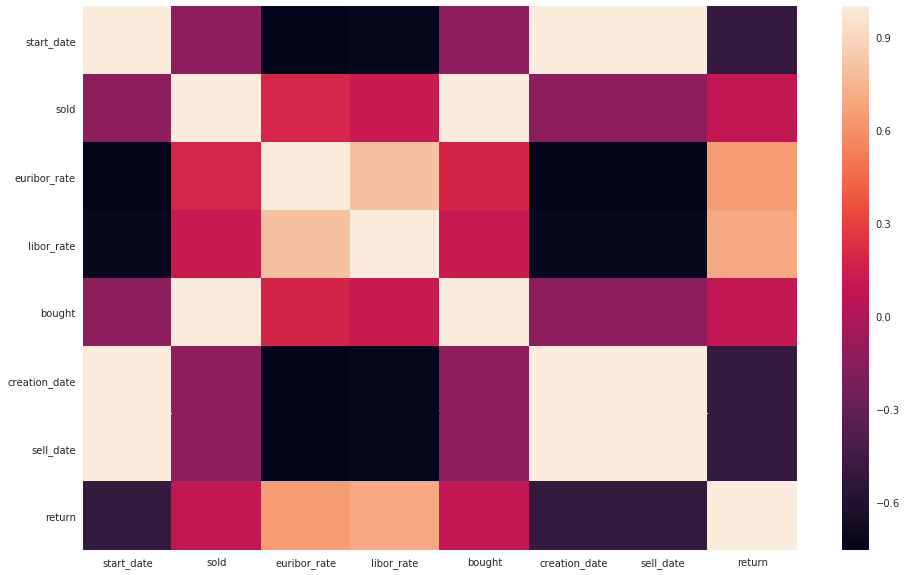

In [11]:
fig, axes = plt.subplots(1, figsize= (16,10))
ax = sns.heatmap(df_train.corr())

In [12]:
df_train.corr()['return'].sort_values(ascending = False)

return           1.000000
libor_rate       0.701278
euribor_rate     0.648551
sold             0.087032
bought           0.086447
sell_date       -0.503353
creation_date   -0.504261
start_date      -0.504295
Name: return, dtype: float64

In [13]:
print(df_train.pf_category.unique())
print(df_test.pf_category.unique())

['B' 'A' 'C' 'D' 'E']
['A' 'B' 'C' 'D']


In [14]:
pd.get_dummies(df_train['pf_category'])

,A,B,C,D,E
0,0,1,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,0,1,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [15]:
pd.get_dummies(df_test['pf_category'])

,A,B,C,D
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,1,0,0,0


In [16]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['pf_category'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['pf_category'])], axis=1)
df_test['E'] = 0

In [17]:
df_train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,sell_date,type,hedge_value,status,return,A,B,C,D,E
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,...,20040812,B,NaN,NaN,0.02496,0,1,0,0,0
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,...,20040812,C,NaN,NaN,0.05496,1,0,0,0,0
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,...,20040817,A,NaN,NaN,0.02496,1,0,0,0,0
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,...,20040713,A,NaN,NaN,0.02496,1,0,0,0,0
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,...,20040713,B,NaN,NaN,0.02496,0,1,0,0,0


In [18]:
df_test.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,indicator_code,sell_date,type,hedge_value,status,A,B,C,D,E
0,PF00001001,DSK00001001,OFF00001001,A,20040720,171831000.0,T,0.02074,USD,2.332216,...,NaN,20040812,A,NaN,NaN,1,0,0,0,0
1,PF00001004,DSK00001003,OFF00001002,B,20040723,56485000.0,T,0.02074,USD,2.332216,...,NaN,20040719,B,NaN,NaN,0,1,0,0,0
2,PF00001009,DSK00001007,OFF00001001,A,20040607,41734000.0,T,0.02074,USD,2.332216,...,NaN,20040709,A,NaN,NaN,1,0,0,0,0
3,PF00001013,DSK00001011,OFF00001001,A,20040716,82951000.0,T,0.02074,USD,2.332216,...,NaN,20041019,A,NaN,NaN,1,0,0,0,0
4,PF00001014,DSK00001012,OFF00001001,A,20040713,73293000.0,T,0.02074,USD,2.332216,...,NaN,20040813,A,NaN,NaN,1,0,0,0,0


In [19]:
df_train.corr()['return'].sort_values(ascending = False)

return           1.000000
libor_rate       0.701278
euribor_rate     0.648551
D                0.532022
A                0.292844
sold             0.087032
bought           0.086447
E                0.037183
B               -0.120296
C               -0.412088
sell_date       -0.503353
creation_date   -0.504261
start_date      -0.504295
Name: return, dtype: float64

In [20]:
df_train.hedge_value.unique()

array([nan, True, False], dtype=object)

In [21]:
df_test.hedge_value.unique()

array([nan, True, False], dtype=object)

In [22]:
df_train['hedge_value'].value_counts()

False    2437
True     1228
Name: hedge_value, dtype: int64

In [24]:
pd.get_dummies(df_train['hedge_value'], prefix = 'hedge_value')

,hedge_value_False,hedge_value_True
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [25]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['hedge_value'], prefix = 'hedge_value')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['hedge_value'], prefix = 'hedge_value')], axis=1)

In [26]:
df_train.corr()['hedge_value_False'].sort_values(ascending = False)

hedge_value_False    1.000000
sell_date            0.769405
creation_date        0.766439
start_date           0.766334
B                    0.181250
C                    0.106116
E                   -0.008667
bought              -0.112629
sold                -0.112804
D                   -0.136162
A                   -0.190978
hedge_value_True    -0.230374
return              -0.286001
libor_rate          -0.375516
euribor_rate        -0.485147
Name: hedge_value_False, dtype: float64

In [27]:
df_train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,hedge_value,status,return,A,B,C,D,E,hedge_value_False,hedge_value_True
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,...,NaN,NaN,0.02496,0,1,0,0,0,0,0
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,...,NaN,NaN,0.05496,1,0,0,0,0,0,0
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,...,NaN,NaN,0.02496,1,0,0,0,0,0,0
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,...,NaN,NaN,0.02496,1,0,0,0,0,0,0
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,...,NaN,NaN,0.02496,0,1,0,0,0,0,0


In [28]:
df_test.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,type,hedge_value,status,A,B,C,D,E,hedge_value_False,hedge_value_True
0,PF00001001,DSK00001001,OFF00001001,A,20040720,171831000.0,T,0.02074,USD,2.332216,...,A,NaN,NaN,1,0,0,0,0,0,0
1,PF00001004,DSK00001003,OFF00001002,B,20040723,56485000.0,T,0.02074,USD,2.332216,...,B,NaN,NaN,0,1,0,0,0,0,0
2,PF00001009,DSK00001007,OFF00001001,A,20040607,41734000.0,T,0.02074,USD,2.332216,...,A,NaN,NaN,1,0,0,0,0,0,0
3,PF00001013,DSK00001011,OFF00001001,A,20040716,82951000.0,T,0.02074,USD,2.332216,...,A,NaN,NaN,1,0,0,0,0,0,0
4,PF00001014,DSK00001012,OFF00001001,A,20040713,73293000.0,T,0.02074,USD,2.332216,...,A,NaN,NaN,1,0,0,0,0,0,0


In [29]:
df_train.corr()['return'].sort_values(ascending = False)

return               1.000000
libor_rate           0.701278
euribor_rate         0.648551
D                    0.532022
A                    0.292844
sold                 0.087032
bought               0.086447
E                    0.037183
B                   -0.120296
hedge_value_True    -0.214977
hedge_value_False   -0.286001
C                   -0.412088
sell_date           -0.503353
creation_date       -0.504261
start_date          -0.504295
Name: return, dtype: float64

In [30]:
df_train.office_id.unique()

array(['OFF00001002', 'OFF00001001'], dtype=object)

In [31]:
pd.get_dummies(df_train['office_id'], prefix = 'office_id')

,office_id_OFF00001001,office_id_OFF00001002
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
5,1,0
6,1,0
7,0,1
8,1,0
9,1,0


In [32]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['office_id'], prefix = 'office_id')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['office_id'], prefix = 'office_id')], axis=1)

In [33]:
df_train.status.unique()

array([nan, True], dtype=object)

In [34]:
pd.get_dummies(df_train['status'], prefix = 'status')

,status_True
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [35]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['status'], prefix = 'status')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['status'], prefix = 'status')], axis=1)

In [36]:
df_train.corr()['return'].sort_values(ascending = False)

return                   1.000000
libor_rate               0.701278
euribor_rate             0.648551
D                        0.532022
office_id_OFF00001001    0.530307
A                        0.292844
sold                     0.087032
bought                   0.086447
E                        0.037183
B                       -0.120296
hedge_value_True        -0.214977
hedge_value_False       -0.286001
C                       -0.412088
sell_date               -0.503353
creation_date           -0.504261
start_date              -0.504295
office_id_OFF00001002   -0.530307
status_True             -0.628951
Name: return, dtype: float64

In [37]:
df_train.type.unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G', 'H'], dtype=object)

In [38]:
df_test.type.unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'H'], dtype=object)

In [39]:
pd.get_dummies(df_train['type'], prefix = 'type')

,type_A,type_B,type_C,type_D,type_E,type_F,type_G,type_H
0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0


In [40]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['type'], prefix = 'type')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['type'], prefix = 'type')], axis=1)

In [41]:
df_test['type_G'] = 0

In [42]:
df_train.corr()['return'].sort_values(ascending = False)

return                   1.000000
libor_rate               0.701278
euribor_rate             0.648551
D                        0.532022
office_id_OFF00001001    0.530307
A                        0.292844
type_A                   0.237041
type_C                   0.114580
sold                     0.087032
bought                   0.086447
E                        0.037183
type_H                   0.018767
type_G                  -0.005346
type_D                  -0.017167
type_F                  -0.061563
B                       -0.120296
type_B                  -0.144749
type_E                  -0.179174
hedge_value_True        -0.214977
hedge_value_False       -0.286001
C                       -0.412088
sell_date               -0.503353
creation_date           -0.504261
start_date              -0.504295
office_id_OFF00001002   -0.530307
status_True             -0.628951
Name: return, dtype: float64

In [43]:
df_train.currency.unique()

array(['USD', 'GBP', 'CHF', 'EUR', 'JPY'], dtype=object)

In [44]:
df_test.currency.unique()

array(['USD', 'GBP', 'CHF', 'EUR', 'JPY'], dtype=object)

In [45]:
pd.get_dummies(df_train['currency'], prefix = 'currency')

,currency_CHF,currency_EUR,currency_GBP,currency_JPY,currency_USD
0,0,0,0,0,1
1,0,0,1,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,0,1
8,0,0,0,0,1
9,0,0,0,0,1


In [45]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['currency'], prefix = 'currency')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['currency'], prefix = 'currency')], axis=1)

In [46]:
df_train.corr()['return'].sort_values(ascending = False)

return                   1.000000
libor_rate               0.701278
euribor_rate             0.648551
currency_EUR             0.533179
D                        0.532022
office_id_OFF00001001    0.530307
A                        0.292844
type_A                   0.237041
currency_USD             0.141467
currency_GBP             0.114580
type_C                   0.114580
sold                     0.087032
bought                   0.086447
E                        0.037183
type_H                   0.018767
type_G                  -0.005346
type_D                  -0.017167
currency_JPY            -0.061563
type_F                  -0.061563
B                       -0.120296
type_B                  -0.144749
type_E                  -0.179174
hedge_value_True        -0.214977
hedge_value_False       -0.286001
C                       -0.412088
currency_CHF            -0.415075
sell_date               -0.503353
creation_date           -0.504261
start_date              -0.504295
office_id_OFF0

In [47]:
df_train.indicator_code.unique()

array([nan, True], dtype=object)

In [48]:
df_test.indicator_code.unique()

array([nan, True], dtype=object)

In [49]:
pd.get_dummies(df_train['indicator_code'], prefix = 'indicator_code')

,indicator_code_True
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [50]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['indicator_code'], prefix = 'indicator_code')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['indicator_code'], prefix = 'indicator_code')], axis=1)

In [51]:
df_train.corr()['hedge_value_True'].sort_values(ascending = False)

hedge_value_True         1.000000
indicator_code_True      0.484266
status_True              0.257367
office_id_OFF00001002    0.197087
sell_date                0.176679
start_date               0.174658
creation_date            0.174515
currency_CHF             0.164176
C                        0.162789
type_E                   0.125430
type_F                   0.086524
currency_JPY             0.086524
type_B                   0.058194
B                        0.029436
type_D                   0.008227
type_G                  -0.004014
E                       -0.005677
type_H                  -0.010624
currency_GBP            -0.068842
type_C                  -0.068842
D                       -0.089188
currency_EUR            -0.090382
bought                  -0.091801
sold                    -0.091913
currency_USD            -0.111932
type_A                  -0.154457
A                       -0.162374
libor_rate              -0.182309
office_id_OFF00001001   -0.197087
return        

# sold - bought

In [52]:
#df_train['sold_bought'] = df_train['sold'] - df_train['bought']
#df_test['sold_bought'] = df_test['sold'] - df_test['bought']

In [53]:
df_train.shape

(9366, 42)

In [54]:
df_test.shape

(4801, 41)

In [55]:
df_train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,type_E,type_F,type_G,type_H,currency_CHF,currency_EUR,currency_GBP,currency_JPY,currency_USD,indicator_code_True
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,...,0,0,0,0,0,0,1,0,0,0
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0


In [56]:
df_test.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,type_E,type_F,type_H,type_G,currency_CHF,currency_EUR,currency_GBP,currency_JPY,currency_USD,indicator_code_True
0,PF00001001,DSK00001001,OFF00001001,A,20040720,171831000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
1,PF00001004,DSK00001003,OFF00001002,B,20040723,56485000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
2,PF00001009,DSK00001007,OFF00001001,A,20040607,41734000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
3,PF00001013,DSK00001011,OFF00001001,A,20040716,82951000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0
4,PF00001014,DSK00001012,OFF00001001,A,20040713,73293000.0,T,0.02074,USD,2.332216,...,0,0,0,0,0,0,0,0,1,0


In [57]:
libor_rate_list = []
count = 0
for index, row in df_train.iterrows():
    if pd.isnull(row['libor_rate']):
        count += 1
        rate = row['euribor_rate']
        x1 = 0
        x2 = 0
        for index1, row1 in df_train.iterrows():
            if rate == row1['euribor_rate']:
                if row1['currency'] == 'GBP':
                    x1 = row1['libor_rate']
                elif row1['currency'] == 'USD':
                    x2 = row1['libor_rate']
            if float(x1) != 0 and float(x2) != 0:
                df_train.loc[index,'libor_rate'] = sqrt((x1-x2)*(x1-x2))
                break
        if x1 == 0 or x2 == 0:
            df_train.loc[index,'libor_rate'] = sqrt((x1-x2)*(x1-x2))

In [58]:
libor_rate_list = []
count = 0
for index, row in df_test.iterrows():
    if pd.isnull(row['libor_rate']):
        count += 1
        rate = row['euribor_rate']
        x1 = 0
        x2 = 0
        for index1, row1 in df_test.iterrows():
            if rate == row1['euribor_rate']:
                if row1['currency'] == 'GBP':
                    x1 = row1['libor_rate']
                elif row1['currency'] == 'USD':
                    x2 = row1['libor_rate']
            if float(x1) != 0 and float(x2) != 0:
                df_test.loc[index,'libor_rate'] = sqrt((x1-x2)*(x1-x2))
                break
        if x1 == 0 or x2 == 0:
            df_test.loc[index,'libor_rate'] = sqrt((x1-x2)*(x1-x2))

In [59]:
year = []
for item in df_train['start_date']:
    year.append(floor(item/10000))
df_train['start_date_year'] = year
year = []
for item in df_train['creation_date']:
    year.append(floor(item/10000))
df_train['creation_date_year'] = year
year = []
for item in df_train['sell_date']:
    year.append(floor(item/10000))
df_train['sell_date_year'] = year

In [60]:
month = []
for item in df_train['start_date']:
    month.append((floor(item/100)%100))
df_train['start_date_month'] = month
month = []
for item in df_train['creation_date']:
    month.append((floor(item/100)%100))
df_train['creation_date_month'] = month
month = []
for item in df_train['sell_date']:
    month.append((floor(item/100)%100))
df_train['sell_date_month'] = month

In [61]:
day = []
for item in df_train['start_date']:
    day.append(item%100)
df_train['start_date_day'] = day
day = []
for item in df_train['creation_date']:
    day.append(item%100)
df_train['creation_date_day'] = day
day = []
for item in df_train['sell_date']:
    day.append(item%100)
df_train['sell_date_day'] = day

In [62]:
df_train['creation_date_days'] = (365 * df_train['creation_date_year'] + (12 * df_train['creation_date_month'] - 30) + df_train['creation_date_day'])
df_train['start_date_days'] = (365 * df_train['start_date_year'] + (12 * df_train['start_date_month'] - 30) + df_train['start_date_day'])
df_train['sell_date_days'] = (365 * df_train['sell_date_year'] + (12 * df_train['sell_date_month'] - 30) + df_train['sell_date_day'])

In [63]:
year = []
for item in df_test['start_date']:
    year.append(floor(item/10000))
df_test['start_date_year'] = year
year = []
for item in df_test['creation_date']:
    year.append(floor(item/10000))
df_test['creation_date_year'] = year
year = []
for item in df_test['sell_date']:
    year.append(floor(item/10000))
df_test['sell_date_year'] = year

In [64]:
month = []
for item in df_test['start_date']:
    month.append((floor(item/100)%100))
df_test['start_date_month'] = month
month = []
for item in df_test['creation_date']:
    month.append((floor(item/100)%100))
df_test['creation_date_month'] = month
month = []
for item in df_test['sell_date']:
    month.append((floor(item/100)%100))
df_test['sell_date_month'] = month

In [65]:
day = []
for item in df_test['start_date']:
    day.append(item%100)
df_test['start_date_day'] = day
day = []
for item in df_test['creation_date']:
    day.append(item%100)
df_test['creation_date_day'] = day
day = []
for item in df_test['sell_date']:
    day.append(item%100)
df_test['sell_date_day'] = day

In [66]:
df_test['creation_date_days'] = (365 * df_test['creation_date_year'] + (12 * df_test['creation_date_month'] - 30) + df_test['creation_date_day'])
df_test['start_date_days'] = (365 * df_test['start_date_year'] + (12 * df_test['start_date_month'] - 30) + df_test['start_date_day'])
df_test['sell_date_days'] = (365 * df_test['sell_date_year'] + (12 * df_test['sell_date_month'] - 30) + df_test['sell_date_day'])

# ADDING DESK_ID AS A BOOLEAN FUNCTION

In [67]:
df_train['desk_id']

0       DSK00001001
1       DSK00001002
2       DSK00001004
3       DSK00001005
4       DSK00001005
5       DSK00001006
6       DSK00001009
7       DSK00001009
8       DSK00001010
9       DSK00001014
10      DSK00001016
11      DSK00001017
12      DSK00001017
13      DSK00001018
14      DSK00001022
15      DSK00001023
16      DSK00001024
17      DSK00001025
18      DSK00001026
19      DSK00001028
20      DSK00001029
21      DSK00001030
22      DSK00001031
23      DSK00001032
24      DSK00001033
25      DSK00001034
26      DSK00001035
27      DSK00001036
28      DSK00001037
29      DSK00001039
           ...     
9336            NaN
9337            NaN
9338            NaN
9339            NaN
9340            NaN
9341            NaN
9342            NaN
9343            NaN
9344            NaN
9345            NaN
9346            NaN
9347            NaN
9348            NaN
9349            NaN
9350            NaN
9351            NaN
9352            NaN
9353            NaN
9354            NaN


In [68]:
for index, row in df_train.iterrows():
    if pd.isnull(row['desk_id']):
        df_train.loc[index,'desk_id'] = 0
    else:
        df_train.loc[index,'desk_id'] = 1

In [69]:
for index, row in df_test.iterrows():
    if pd.isnull(row['desk_id']):
        df_test.loc[index,'desk_id'] = 0
    else:
        df_test.loc[index,'desk_id'] = 1

In [70]:
df_train.desk_id = df_train.desk_id.astype(int)

In [71]:
df_test.desk_id = df_test.desk_id.astype(int)

In [72]:
list(df_train.columns.values)

['portfolio_id',
 'desk_id',
 'office_id',
 'pf_category',
 'start_date',
 'sold',
 'country_code',
 'euribor_rate',
 'currency',
 'libor_rate',
 'bought',
 'creation_date',
 'indicator_code',
 'sell_date',
 'type',
 'hedge_value',
 'status',
 'return',
 'A',
 'B',
 'C',
 'D',
 'E',
 'hedge_value_False',
 'hedge_value_True',
 'office_id_OFF00001001',
 'office_id_OFF00001002',
 'status_True',
 'type_A',
 'type_B',
 'type_C',
 'type_D',
 'type_E',
 'type_F',
 'type_G',
 'type_H',
 'currency_CHF',
 'currency_EUR',
 'currency_GBP',
 'currency_JPY',
 'currency_USD',
 'indicator_code_True',
 'start_date_year',
 'creation_date_year',
 'sell_date_year',
 'start_date_month',
 'creation_date_month',
 'sell_date_month',
 'start_date_day',
 'creation_date_day',
 'sell_date_day',
 'creation_date_days',
 'start_date_days',
 'sell_date_days']

In [73]:
exclude_column = ['office_id','pf_category','start_date','country_code','currency','creation_date',
 'indicator_code',
 'sell_date',
 'type',
 'hedge_value',
 'status']

In [74]:
for col in exclude_column:
    df_train.pop(col)

In [75]:
for col in exclude_column:
    df_test.pop(col)

In [76]:
df_train.shape

(9366, 43)

In [77]:
df_test.shape

(4801, 42)

In [78]:
list(df_train.columns.values)

['portfolio_id',
 'desk_id',
 'sold',
 'euribor_rate',
 'libor_rate',
 'bought',
 'return',
 'A',
 'B',
 'C',
 'D',
 'E',
 'hedge_value_False',
 'hedge_value_True',
 'office_id_OFF00001001',
 'office_id_OFF00001002',
 'status_True',
 'type_A',
 'type_B',
 'type_C',
 'type_D',
 'type_E',
 'type_F',
 'type_G',
 'type_H',
 'currency_CHF',
 'currency_EUR',
 'currency_GBP',
 'currency_JPY',
 'currency_USD',
 'indicator_code_True',
 'start_date_year',
 'creation_date_year',
 'sell_date_year',
 'start_date_month',
 'creation_date_month',
 'sell_date_month',
 'start_date_day',
 'creation_date_day',
 'sell_date_day',
 'creation_date_days',
 'start_date_days',
 'sell_date_days']

In [79]:
null_columns = df_train.isnull().sum()

In [80]:
null_columns[null_columns > 0]

Series([], dtype: int64)

In [81]:
df_train['sold'] = df_train['sold'].fillna(df_train['sold'].mean())
df_train['bought'] = df_train['bought'].fillna(df_train['bought'].mean())

In [82]:
df_train.head()

,portfolio_id,desk_id,sold,euribor_rate,libor_rate,bought,return,A,B,C,...,sell_date_year,start_date_month,creation_date_month,sell_date_month,start_date_day,creation_date_day,sell_date_day,creation_date_days,start_date_days,sell_date_days
0,PF00001002,1,110000000.0,0.02074,2.332216,1.098097e+08,0.02496,0,1,0,...,2004,7,7,8,20,20,12,731534,731534,731538
1,PF00001003,1,176671000.0,0.02074,5.269617,1.760084e+08,0.05496,1,0,0,...,2004,7,7,8,9,23,12,731537,731523,731538
2,PF00001005,1,56474000.0,0.02074,2.332216,5.637953e+07,0.02496,1,0,0,...,2004,7,7,8,23,23,17,731537,731537,731543
3,PF00001006,1,164813000.0,0.02074,2.332216,1.645088e+08,0.02496,1,0,0,...,2004,6,7,7,9,23,13,731537,731511,731527
4,PF00001007,1,140800000.0,0.02074,2.332216,1.405402e+08,0.02496,0,1,0,...,2004,6,7,7,9,23,13,731537,731511,731527


In [83]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

In [84]:
train_id = df_train.pop('portfolio_id')
test_id = df_test.pop('portfolio_id')
y = df_train.pop('return')

In [85]:
X = df_train

In [89]:
X_test = df_test[['desk_id', 'sold', 'euribor_rate', 'libor_rate', 'bought', 'A', 'B', 'C', 'D', 'E', 'hedge_value_False', 'hedge_value_True', 'office_id_OFF00001001', 'office_id_OFF00001002', 'status_True', 'type_A', 'type_B', 'type_C', 'type_D', 'type_E', 'type_F', 'type_G', 'type_H', 'currency_CHF', 'currency_EUR', 'currency_GBP', 'currency_JPY', 'currency_USD', 'indicator_code_True', 'start_date_year', 'creation_date_year', 'sell_date_year', 'start_date_month', 'creation_date_month', 'sell_date_month', 'start_date_day', 'creation_date_day', 'sell_date_day', 'creation_date_days', 'start_date_days', 'sell_date_days']]

In [109]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  
#                                                    random_state=42)

In [107]:
xclas = XGBRegressor( n_estimators= 5000, max_depth = 9, learning_rate = 0.2)
xclas.fit(X, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=5000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [108]:
xclas.predict(X_test) 

array([ 0.0255883 ,  0.02482688,  0.02498162, ...,  0.00543985,
        0.00577998,  0.00590748], dtype=float32)

In [109]:
df_test['portfolio_id'] = test_id
df_test['return'] = xclas.predict(X_test)

In [110]:
df_test[['portfolio_id','return']].to_csv('predictions_basic_with_status_with_indicator_code_with_deskid_5000_9_lr_0.2.csv', index = False)

In [91]:
xclas.booster().get_score(importance_type='weight')

{'A': 137,
 'B': 43,
 'C': 36,
 'D': 39,
 'E': 23,
 'bought': 505,
 'creation_date_day': 192,
 'creation_date_days': 1232,
 'creation_date_month': 54,
 'creation_date_year': 4,
 'currency_CHF': 39,
 'currency_EUR': 21,
 'currency_USD': 62,
 'desk_id': 31,
 'euribor_rate': 1072,
 'hedge_value_False': 1,
 'hedge_value_True': 23,
 'indicator_code_True': 9,
 'libor_rate': 1090,
 'office_id_OFF00001001': 33,
 'sell_date_day': 654,
 'sell_date_days': 1255,
 'sell_date_month': 523,
 'sell_date_year': 43,
 'sold': 1309,
 'start_date_day': 560,
 'start_date_days': 144,
 'start_date_month': 236,
 'start_date_year': 33,
 'status_True': 72,
 'type_A': 40,
 'type_B': 47,
 'type_C': 80,
 'type_D': 14,
 'type_E': 4,
 'type_F': 46,
 'type_H': 12}